# YOLO.

Напишим и обучим свой собственный YOLO детектор. Нужно будет разобраться со статьей: понять какого формата должна быть обучающая пара (x, y), как перевести лосс из математической формулы в питоновский код - ну и конечно понять и реализовать саму архитектуру модели.

Выборка на котрой мы будем обучать модель состоит из разнообразных фотографий яблок, бананов и апельсинов. Данные скачиваем [отсюда](https://drive.google.com/file/d/1d8GSfZoWbraWCSUhX78yl4CnMFYE-5n3/view?usp=sharing).

In [1]:
# Данная библиотека понадобится нам, чтобы обработать разметку
! pip install xmltodict pytorch-lightning

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 800 kB 3.9 MB/s 
     |████████████████████████████████| 512 kB 41.9 MB/s 
     |████████████████████████████████| 125 kB 57.2 MB/s 


Скачаем данные

In [2]:
!wget --quiet --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://drive.google.com/uc?export=download&id=1d8GSfZoWbraWCSUhX78yl4CnMFYE-5n3' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1d8GSfZoWbraWCSUhX78yl4CnMFYE-5n3" -O data.zip && rm -rf /tmp/cookies.txt
!unzip -q data.zip
!rm data.zip
!ls -l

total 12
drwx------ 4 root root 4096 Nov 26 08:32 data
drwxr-xr-x 3 root root 4096 Dec 19 11:17 __MACOSX
drwxr-xr-x 1 root root 4096 Dec 16 00:01 sample_data


Посмотрим как выглядит один из файлов разметки

In [3]:
!cat data/train/apple_3.xml

<annotation>
	<folder>train</folder>
	<filename>apple_3.jpg</filename>
	<path>C:\tensorflow1\models\research\object_detection\images\train\apple_3.jpg</path>
	<source>
		<database>Unknown</database>
	</source>
	<size>
		<width>1000</width>
		<height>708</height>
		<depth>3</depth>
	</size>
	<segmented>0</segmented>
	<object>
		<name>apple</name>
		<pose>Unspecified</pose>
		<truncated>1</truncated>
		<difficult>0</difficult>
		<bndbox>
			<xmin>584</xmin>
			<ymin>438</ymin>
			<xmax>867</xmax>
			<ymax>708</ymax>
		</bndbox>
	</object>
	<object>
		<name>apple</name>
		<pose>Unspecified</pose>
		<truncated>0</truncated>
		<difficult>0</difficult>
		<bndbox>
			<xmin>492</xmin>
			<ymin>141</ymin>
			<xmax>740</xmax>
			<ymax>394</ymax>
		</bndbox>
	</object>
	<object>
		<name>apple</name>
		<pose>Unspecified</pose>
		<truncated>0</truncated>
		<difficult>0</difficult>
		<bndbox>
			<xmin>176</xmin>
			<ymin>199</ymin>
			<xmax>490</xmax>
			<ymax>466</ymax>
		</bndbox>
	</object>
	<obj

In [4]:
from PIL import Image

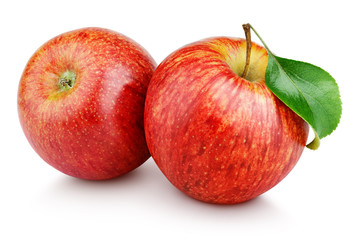

In [5]:
Image.open('data/train/apple_4.jpg')

In [6]:
!ls -l data/train

total 24772
-rw-rw-r-- 1 root root 317019 Oct  2  2019 apple_10.jpg
-rw-rw-r-- 1 root root    560 Oct  2  2019 apple_10.xml
-rw-rw-r-- 1 root root  68922 Oct  2  2019 apple_11.jpg
-rw-rw-r-- 1 root root   1004 Oct  2  2019 apple_11.xml
-rw-rw-r-- 1 root root  38178 Oct  2  2019 apple_12.jpg
-rw-rw-r-- 1 root root    556 Oct  2  2019 apple_12.xml
-rw-rw-r-- 1 root root 139926 Oct  2  2019 apple_13.jpg
-rw-rw-r-- 1 root root   1010 Oct  2  2019 apple_13.xml
-rw-rw-r-- 1 root root 197300 Oct  2  2019 apple_14.jpg
-rw-rw-r-- 1 root root    558 Oct  2  2019 apple_14.xml
-rw-rw-r-- 1 root root  39679 Oct  2  2019 apple_15.jpg
-rw-rw-r-- 1 root root    562 Oct  2  2019 apple_15.xml
-rw-rw-r-- 1 root root  15525 Oct  2  2019 apple_16.jpg
-rw-rw-r-- 1 root root    556 Oct  2  2019 apple_16.xml
-rw-rw-r-- 1 root root 364745 Oct  2  2019 apple_17.jpg
-rw-rw-r-- 1 root root    554 Oct  2  2019 apple_17.xml
-rw-rw-r-- 1 root root  33011 Oct  2  2019 apple_18.jpg
-rw-rw-r-- 1 root root    558 Oct  2

## Релизуем выборку для YoloV1

In [7]:
import os
import cv2
import json
import glob
import tqdm
import xmltodict

from IPython.core.display import struct

from typing import List

import pandas as pd
import numpy as np

import torch
import torchvision
from torch import nn
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader

import pytorch_lightning as pl

import albumentations as A
import albumentations.pytorch

from PIL import Image

import matplotlib.pyplot as plt

from sklearn.metrics import auc

Будем использовать аугментации для обучения, воспользуемся библиотекой albumentations.

Она  особенно удобна, поскольку умеет сама вычислять новые координаты bounding box'ов после трансформаций картинки. [гайд](https://albumentations.ai/docs/getting_started/bounding_boxes_augmentation/). 

In [8]:
# Просто поэкспериментируем, чтобы стало понятно как все работает
obj = '''
<annotation>
	<object>
		<name>apple</name>
		<pose>Unspecified</pose>
		<truncated>1</truncated>
		<difficult>0</difficult>
		<bndbox>
			<xmin>584</xmin>
			<ymin>438</ymin>
			<xmax>867</xmax>
			<ymax>708</ymax>
		</bndbox>
	</object>
	<object>
		<name>apple</name>
		<pose>Unspecified</pose>
		<truncated>0</truncated>
		<difficult>0</difficult>
		<bndbox>
			<xmin>492</xmin>
			<ymin>141</ymin>
			<xmax>740</xmax>
			<ymax>394</ymax>
		</bndbox>
	</object>
	<object>
		<name>apple</name>
		<pose>Unspecified</pose>
		<truncated>0</truncated>
		<difficult>0</difficult>
		<bndbox>
			<xmin>176</xmin>
			<ymin>199</ymin>
			<xmax>490</xmax>
			<ymax>466</ymax>
		</bndbox>
	</object>
	<object>
		<name>apple</name>
		<pose>Unspecified</pose>
		<truncated>0</truncated>
		<difficult>0</difficult>
		<bndbox>
			<xmin>367</xmin>
			<ymin>17</ymin>
			<xmax>619</xmax>
			<ymax>240</ymax>
		</bndbox>
	</object>
	<object>
		<name>apple</name>
		<pose>Unspecified</pose>
		<truncated>0</truncated>
		<difficult>0</difficult>
		<bndbox>
			<xmin>642</xmin>
			<ymin>35</ymin>
			<xmax>907</xmax>
			<ymax>269</ymax>
		</bndbox>
	</object>
</annotation>
'''

In [9]:
doc = xmltodict.parse(obj)

In [10]:
doc['annotation']['object']

[{'name': 'apple',
  'pose': 'Unspecified',
  'truncated': '1',
  'difficult': '0',
  'bndbox': {'xmin': '584', 'ymin': '438', 'xmax': '867', 'ymax': '708'}},
 {'name': 'apple',
  'pose': 'Unspecified',
  'truncated': '0',
  'difficult': '0',
  'bndbox': {'xmin': '492', 'ymin': '141', 'xmax': '740', 'ymax': '394'}},
 {'name': 'apple',
  'pose': 'Unspecified',
  'truncated': '0',
  'difficult': '0',
  'bndbox': {'xmin': '176', 'ymin': '199', 'xmax': '490', 'ymax': '466'}},
 {'name': 'apple',
  'pose': 'Unspecified',
  'truncated': '0',
  'difficult': '0',
  'bndbox': {'xmin': '367', 'ymin': '17', 'xmax': '619', 'ymax': '240'}},
 {'name': 'apple',
  'pose': 'Unspecified',
  'truncated': '0',
  'difficult': '0',
  'bndbox': {'xmin': '642', 'ymin': '35', 'xmax': '907', 'ymax': '269'}}]

In [11]:
boxes = []
class_labels = []

for el in doc['annotation']['object']:
  class_labels.append(el['name'])
  box = []
  for coord in el['bndbox']:
    box.append(el['bndbox'][coord])
  boxes.append(box)
print(boxes, class_labels)

[['584', '438', '867', '708'], ['492', '141', '740', '394'], ['176', '199', '490', '466'], ['367', '17', '619', '240'], ['642', '35', '907', '269']] ['apple', 'apple', 'apple', 'apple', 'apple']


In [12]:
doc = xmltodict.parse(open(glob.glob('./data/train' + '/*.xml')[4], 'r').read())

In [13]:
doc['annotation']['object']

{'name': 'banana',
 'pose': 'Unspecified',
 'truncated': '0',
 'difficult': '0',
 'bndbox': {'xmin': '144', 'ymin': '46', 'xmax': '340', 'ymax': '291'}}

In [14]:
doc = xmltodict.parse(open(glob.glob('./data/train' + '/*.xml')[0], 'r').read())

In [15]:
doc['annotation']['object']

[{'name': 'orange',
  'pose': 'Unspecified',
  'truncated': '0',
  'difficult': '0',
  'bndbox': {'xmin': '313', 'ymin': '153', 'xmax': '478', 'ymax': '348'}},
 {'name': 'apple',
  'pose': 'Unspecified',
  'truncated': '0',
  'difficult': '0',
  'bndbox': {'xmin': '127', 'ymin': '148', 'xmax': '320', 'ymax': '371'}},
 {'name': 'banana',
  'pose': 'Unspecified',
  'truncated': '0',
  'difficult': '0',
  'bndbox': {'xmin': '73', 'ymin': '366', 'xmax': '618', 'ymax': '619'}}]

In [23]:
import xml.etree.ElementTree as ET

In [46]:
class2tag = {"apple": 1, "orange": 2, "banana": 3}

class FruitDataset(Dataset):
    def __init__(self, data_dir, transforms=None):
        self.image_paths = glob.glob(data_dir + '/*.jpg')
        self.box_paths = glob.glob(data_dir + '/*.xml')
        self.box_paths.sort()
        self.image_paths.sort()

        assert len(self.image_paths) == len(self.box_paths)

        self.transforms = transforms

    # Координаты прямоугольников советуем вернуть именно в формате (x_center, y_center, width, height)
    def __getitem__(self, idx):
        # Предполагается, что объект выглядит так: (img, (boxes, labels))
        image = np.array(Image.open(self.image_paths[idx]).convert("RGB"))
        boxes, class_labels = self.__get_boxes_from_xml(self.box_paths[idx])

        new_boxes = []
        for i in range(len(boxes)):
          new_boxes.append(self.__convert_to_yolo_box_params(boxes[i], 
                                                              image.shape[1], 
                                                              image.shape[0]))

        if self.transforms:
          transformed = self.transforms(image=image, bboxes=new_boxes, class_labels=class_labels)

        return torch.unsqueeze(torch.permute(torch.tensor(transformed['image']), [2, 0, 1]), dim=0), (transformed['bboxes'], transformed['class_labels'])

    def __len__(self):
        return len(self.image_paths)

    def __get_boxes_from_xml(self, xml_filename: str):
      """
      Метод, который считает и распарсит (с помощью xmltodict) переданный xml
      файл и вернет координаты прямоугольников обьектов на соответсвующей фотографии
      и название класса обьекта в каждом прямоугольнике

      Обратите внимание, что обьектов может быть как несколько, так и один единственный
      """
      boxes = []
      class_labels = []

      doc = xmltodict.parse(open(xml_filename, 'r').read())
      if type(doc['annotation']['object']) == list:
        for el in doc['annotation']['object']:
          class_labels.append(class2tag[el['name']])
          box = []
          for coord in el['bndbox']:
            box.append(int(el['bndbox'][coord]))
          boxes.append(box)
      else:
        class_labels.append(class2tag[doc['annotation']['object']['name']])
        box = []
        for coord in doc['annotation']['object']['bndbox']:
          box.append(int(doc['annotation']['object']['bndbox'][coord]))
        boxes.append(box)

      return boxes, class_labels

    def __convert_to_yolo_box_params(self, box_coordinates: List[int], im_w, im_h):
      """
      Перейти от [xmin, ymin, xmax, ymax] к [x_center, y_center, width, height].
      
      Обратите внимание, что параметры [x_center, y_center, width, height] - это
      относительные значение в отрезке [0, 1]

      :param: box_coordinates - координаты коробки в формате [xmin, ymin, xmax, ymax]
      :param: im_w - ширина исходного изображения
      :param: im_h - высота исходного изображения

      :return: координаты коробки в формате [x_center, y_center, width, height]
      """
      ans = []

      ans.append((box_coordinates[0] + box_coordinates[2]) / 2 / im_w)  # x_center
      ans.append((box_coordinates[1] + box_coordinates[3]) / 2 / im_h)  # y_center
      
      ans.append((box_coordinates[2] - box_coordinates[0]) / im_w)  # width
      ans.append((box_coordinates[3] - box_coordinates[1]) / im_h)  # height
      return ans

In [44]:
WIDTH, HEIGHT = 448, 448

train_transform =A.Compose([
    A.Resize(WIDTH, HEIGHT),
    A.RandomCrop(width=WIDTH, height=HEIGHT),
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.2),
    A.Normalize((0.5, 0.5, 0.5), (1, 1, 1)),
], bbox_params=A.BboxParams(format='yolo', min_visibility=0.2, label_fields=['class_labels']))

test_transform = A.Compose([
    A.Resize(WIDTH, HEIGHT),
    A.Normalize((0.5, 0.5, 0.5), (1, 1, 1)),
], bbox_params=A.BboxParams(format='yolo', min_visibility=0.2, label_fields=['class_labels']))

In [47]:
train_dataset = FruitDataset(
    transforms=train_transform,
    data_dir="./data/train"
    )

val_dataset = FruitDataset(
    transforms=test_transform, 
    data_dir="./data/test"
    )

# Немного проверок, чтобы убедиться в правильности направления решения
assert isinstance(train_dataset[0], tuple)
assert len(train_dataset[0]) == 2
assert isinstance(train_dataset[0][0], torch.Tensor)
print("Тесты успешно пройдены")

Тесты успешно пройдены


In [48]:
train_dataloader = DataLoader(
    dataset=train_dataset,
    batch_size= 4,
    shuffle=True)

val_dataloader = DataLoader(
    dataset=val_dataset,
    batch_size=4, 
    shuffle=False
    )

In [40]:
from PIL import ImageDraw, ImageOps

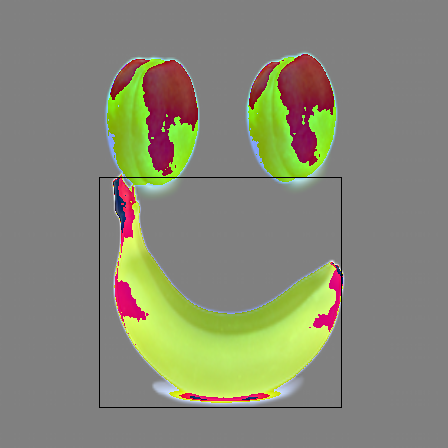

In [49]:
im = ImageOps.invert(torchvision.transforms.ToPILImage()(torch.squeeze(train_dataset[100][0], dim=0)))
draw = ImageDraw.Draw(im)
for box in train_dataset[100][1][0]:
    x = 448 * box[0]
    y = 448 * box[1]
    w = 448 * box[2]
    h = 448 * box[3]
    draw.rectangle([(x - w//2, y - h//2), (x + w//2, y + h//2)], outline='black')
im

Теперь определим функцию для рассчета Intersection Over Union по 4 углам двух прямоугольников

In [12]:
def intersection_over_union(predicted_bbox, gt_bbox) -> float:
    """
    Intersection Over Union для двух прямоугольников

    :param: predicted_bbox - [x_min, y_min, x_max, y_max]
    :param: gt_bbox - [x_min, y_min, x_max, y_max]
    
    :return: Intersection Over Union
    """

    intersection_bbox = np.array(
        [
            max(predicted_bbox[0], gt_bbox[0]),
            max(predicted_bbox[1], gt_bbox[1]),
            min(predicted_bbox[2], gt_bbox[2]),
            min(predicted_bbox[3], gt_bbox[3]),
        ]
    )

    intersection_area = max(intersection_bbox[2] - intersection_bbox[0], 0) * max(
        intersection_bbox[3] - intersection_bbox[1], 0
    )
    area_dt = (predicted_bbox[2] - predicted_bbox[0]) * (predicted_bbox[3] - predicted_bbox[1])
    area_gt = (gt_bbox[2] - gt_bbox[0]) * (gt_bbox[3] - gt_bbox[1])

    union_area = area_dt + area_gt - intersection_area

    iou = intersection_area / union_area
    return float(iou)

Обучим модель YOLO для object detection на __обучающем__ датасете. 

 - Создадим модель и функцию ошибки YoloV1, прочитав [оригинальную статью](https://paperswithcode.com/paper/you-only-look-once-unified-real-time-object)
 - Напишим функцию обучения модели
 - Используем аугментации

## Реализуем Модель

Копировать точное количество слоев и параметры сверток необязательно. Главное - чтобы модель работала по принципу, описанному в статье и делала предсказание в представленном формате.

Выходом модели __для каждого обьекта__ должен быть тензор размера
__S * S * (B * 5 + С)__, где все параметры имеют такое же значение, как и в статье: 

- S - количество ячеек на которое разбивается изображение по вертикали/горизонтали
- В - количество предсказываемых прямоугольников в каждой ячейке
- 5 - количество параметров для определения каждого прямоугольника (x_center, y_center, width, height, confidence)
- С - количество классов (apple, banana, orange)

Таким образом, мы для каждого окна размера __S x S__ предсказываем __В__ коробо и один класс

In [55]:
train_dataset[0][1]

([(0.48567335243553006,
   0.5214899713467048,
   0.9255014326647565,
   0.9570200573065903)],
 [1])

In [50]:
train_dataset[0][0].shape

torch.Size([1, 3, 448, 448])

In [13]:
class CNNBlock(nn.Module):  # можно поменять на Lightning
    def __init__(self, in_channels, out_channels, is_max_pool:bool=False, **kwargs):
        
        super().__init__()

        self.conv = nn.Conv2d(in_channels, out_channels, **kwargs)
        self.batchnorm = nn.BatchNorm2d(out_channels)  # в статье еще не знали про батчнорм, но мы то из будущего ...
        self.leakyrelu = nn.LeakyReLU(0.1)

        self.is_maxpool = is_max_pool  # не после каждой свертки нужно делать maxpool
        self.maxpool = nn.MaxPool2d(2)
        
    def forward(self, x):
        x = self.leakyrelu(self.batchnorm(self.conv(x)))

        if self.is_maxpool:
            x = self.maxpool(x)

        return x

class YOLO(nn.Module):
    def __init__(self, S=7, B=2, C=3):
        """
        :param: S * S - количество ячеек на которые разбивается изображение
        :param: B - количество предсказанных прямоугольников в каждой ячейке
        :param: C - количество классов
        """
        
        super(YOLO, self).__init__();

        self.S = S
        self.B = B
        self.C = C
        self.last = nn.Sequential(
            nn.Flatten(),
            nn.Linear(1024 * self.S * self.S, 4096),
            nn.Dropout(0.5),
            nn.LeakyReLU(0.1),
            nn.Linear(4096, self.S * self.S * (self.C + self.B * 5))
        )
        self.flatten = nn.Flatten()
        self.in_channels = 3
        self.darknet = self._create_darknet()

    def _create_darknet(self):
        all_layers = []
        in_channels = self.in_channels

        self.block1 = [CNNBlock(in_channels, 64, is_max_pool=True, kernel_size=7, stride=2, padding=3)]
        in_channels = 64
        self.block2 = [CNNBlock(in_channels, 192, is_max_pool=True, kernel_size=3, stride=1, padding=1)]
        in_channels = 192
        self.block3 = [CNNBlock(in_channels, 128, kernel_size=1, stride=1, padding=0)]
        in_channels = 128
        self.block4 = [CNNBlock(in_channels, 256, kernel_size=3, stride=1, padding=1)]
        in_channels = 256
        self.block5 = [CNNBlock(in_channels, 256, kernel_size=1, stride=1, padding=0)]
        self.block6 = [CNNBlock(in_channels, 512, is_max_pool=True, kernel_size=3, stride=1, padding=1)]
        in_channels = 512
        all_layers += self.block1 + self.block2 + self.block3 + self.block4 + self.block5 + self.block6

        self.block7 = [CNNBlock(in_channels, 256, kernel_size=1, stride=1, padding=0)] 
        in_channels = 256
        self.block8 = [CNNBlock(in_channels, 512, kernel_size=3, stride=1, padding=1)]
        in_channels = 512
        for i in range(4):
            all_layers += self.block7 + self.block8

        self.block9 = [CNNBlock(in_channels, 512, kernel_size=1, stride=1, padding=0)] 
        in_channels = 512
        self.block10 = [CNNBlock(in_channels, 1024, is_max_pool=True, kernel_size=3, stride=1, padding=1)]
        in_channels = 1024
        all_layers += self.block9 + self.block10
          
        self.block11 = [CNNBlock(in_channels, 512, kernel_size=1, stride=1, padding=0)] 
        in_channels = 512
        self.block12 = [CNNBlock(in_channels, 1024, kernel_size=3, stride=1, padding=1)]
        in_channels = 1024
        for i in range(2):
            all_layers += self.block11 + self.block12

        self.block13 = [CNNBlock(in_channels, 1024, kernel_size=3, stride=1, padding=1)]
        self.block14 = [CNNBlock(in_channels, 1024, kernel_size=3, stride=2, padding=1)]
        all_layers += self.block13 + self.block14 + self.block13 + self.block13

        return nn.Sequential(*all_layers)

    def forward(self, x):
        x = self.darknet(x)
        x = self.last(x)
        return x


# Убедимся на одном изображении, что предсказания вашей модели имеют верное количество значений

testing_model = YOLO()
expected_output_shape = testing_model.S * testing_model.S * (5 * testing_model.B + testing_model.C)

testing_image = train_dataset[0][0]

assert testing_model(testing_image).reshape(-1).shape[0] == expected_output_shape

In [ ]:
# Ура, все сработало - картинка прошла по сетке без ошибок и даже нужного размера вернулась

Напишу, пожалуй, как выглядит сетка тут, а то по коду не очень понятно:

darknet:
1. conv* 7x7 s=2 padding=3 out_channels=64
2. maxpool 2x2
3. conv* 3x3 s=1 padding=1 out_channels=192
4. maxpool 2x2
5. conv* 1x1 s=1 padding=0 out_channels=128
6. conv* 3x3 s=1 padding=1 out_channels=256
7. conv* 1x1 s=1 padding=0 out_channels=256
8. conv* 3x3 s=1 padding=1 out_channels=512
9. maxpool 2x2
10. conv* 1x1 s=1 padding=0 out_channels=256 && conv 3x3 s=1 padding=1 out_channels=512 -- repeat 4 times
11. conv* 1x1 s=1 padding=0 out_channels=512
12. conv* 3x3 s=1 padding=1 out_channels=1024
13. maxpool 2x2
14. conv* 1x1 s=1 padding=0 out_channels=512 && conv 3x3 s=1 padding=1 out_channels=1024 -- repeat 2 times
15. conv* 3x3 s=1 padding=1 out_channels=1024
16. conv* 3x3 s=2 padding=1 out_channels=1024
17. conv* 3x3 s=1 padding=1 out_channels=1024
18. conv* 3x3 s=1 padding=1 out_channels=1024

conv* означает наш CNN блок, то есть комбинация из обычной конволюции, batchnorm и leakyrelu

И в завершении:
1. flatten
2. Linear(1024 * S * S, 4096)
3. dropout(p=0.5)
4. LeakyReLU(0.1)
5. Linear(4096, S * S * (C + B * 5))

## Реализуем YoloLoss

In [14]:
class YoloLoss(nn.Module):
    def __init__(self, S=7, B=2, C=3):
        """
        :param: S * S - количество ячеек на которые разбивается изображение
        :param: B - количество предсказанных прямоугольников в каждой ячейке
        :param: C - количество классов
        """
        super().__init__()
        self.mse = nn.MSELoss(reduction="sum") 

        self.S = S
        self.B = B
        self.C = C

        self.lambda_noobj = 0.5
        self.lambda_coord = 5

    def forward(self, predictions, target):  
        predictions = predictions.reshape(-1, self.S, self.S, self.C + self.B * 5)  # изначально наши предсказания имеют размер (размер батча, S*S(C+B*5))
        # Считаем iou для двух боксов, которые мы предсказали, с истинным боксом
        iou_box1 = intersection_over_union(predictions[..., self.C + 1:self.C + 5], target[..., self.C + 1:self.C + 5])
        iou_box2 = intersection_over_union(predictions[..., self.C + 6:self.C + 10], target[..., self.C + 1:self.C + 5])

        # Берем бокс c максимальным iou
        _, bestbox = torch.max(torch.cat([iou_box1.unsqueeze(0), iou_box2.unsqueeze(0)], dim=0), dim=0)
        Iobj_i = target[..., self.C].unsqueeze(3)

        # Iobj_i - маска на то, есть ли объект в боксе. Берем тот бокс, у которого iou лучше
        box_predictions = Iobj_i * ((bestbox * predictions[..., self.C + 6:self.C + 10] + 
                                         (1 - bestbox) * predictions[..., self.C + 1:self.C + 5]))
        box_targets = Iobj_i * target[..., self.C + 1:self.C + 5]

        # ------------------------------------------------------------
        # loss координат
        # Извлекаем корень, поэтому не забываем брать абсолютное значение перед этим, чтобы не было undefiend behaviour
        box_predictions[..., 2:4] = torch.sign(box_predictions[..., 2:4]) * \
        torch.sqrt(torch.abs(box_predictions[..., 2:4] + 1e-6)) # тут 1e-6, так как хотим численную стабильность
        box_targets[..., 2:4] = torch.sqrt(box_targets[..., 2:4])
        box_loss = self.mse(torch.flatten(box_predictions, end_dim=-2), torch.flatten(box_targets, end_dim=-2))

        # ------------------------------------------------------------
        # Так называемый class loss
        class_loss = self.mse(torch.flatten(Iobj_i * predictions[..., :self.C], end_dim=-2), 
                              torch.flatten(Iobj_i * target[..., :self.C], end_dim=-2))

        # ------------------------------------------------------------
        # Так называемый object loss
        # pred_box - уверенность для того бокса, у которого самый высокий iou
        pred_box = (bestbox * predictions[..., self.C + 5:self.C + 6] + \
                    (1 - bestbox) * predictions[..., self.C:self.C + 1])
        obj_loss = self.mse(torch.flatten(Iobj_i * pred_box), 
                               torch.flatten(Iobj_i * target[..., self.C:self.C + 1]))

        # ------------------------------------------------------------
        # Так называемый no object loss
        no_obj_loss = self.mse(torch.flatten((1 - Iobj_i) * predictions[..., self.C:self.C + 1], start_dim=1), 
                                  torch.flatten((1 - Iobj_i) * target[..., self.C:self.C + 1], start_dim=1))
        no_obj_loss += self.mse(torch.flatten((1 - Iobj_i) * predictions[..., self.C + 5:self.C + 6], start_dim=1), # Для обоих предсказаний
                                   torch.flatten((1 - Iobj_i) * target[..., self.C:self.C + 1], start_dim=1))

        # ------------------------------------------------------------
        # Итого
        loss = (self.lambda_coord * box_loss + obj_loss + 
                self.lambda_noobj * no_obj_loss + class_loss)

        return loss

In [ ]:
# Это как-то тяжко тестить, может потом, на обучении... Но эту штуку я глазами много раз проверял

## Реализуем дополнительные функции из статьи 

In [15]:
def non_max_suppression(bboxes, iou_threshold, threshold):
    # в bboxes у нас элемент выглядит следующим образом: [class_pred, prob_score, x1, y1, x2, y2]

    boxes = [box for box in bboxes if box[1] > threshold] # отсеиваем те, которое меньше трешхолда
    boxes = sorted(bboxes, key=lambda x: x[1], reverse=True) # сортим по предсказанным вероятностям
    new_bboxes = []

    # Проводим отбор
    while boxes:
        our_box = boxes.pop(0)  
        boxes = [box for box in boxes 
                 if box[0] != our_box[0] or 
                 intersection_over_union(torch.tensor(our_box[2:]), 
                                         torch.tensor(box[2:])) < iou_threshold]
        new_bboxes.append(our_box)  

    return new_bboxes

In [16]:
# Тестируем
non_max_suppression([[0, 0.4, 0, 0, 2, 2], [0, 0.6, 0, 0, 2, 3], 
                     [0, 0.7, 0, 0, 3, 2], [0, 0.3, 0, 0, 2, 2], 
                     [0, 0.8, 0, 0, 3, 3], [0, 0.8, 4, 4, 8, 8]],
                    0.4, 0.5)

[[0, 0.8, 0, 0, 3, 3], [0, 0.8, 4, 4, 8, 8]]

In [ ]:
# Работает))

In [17]:
from collections import Counter

def mean_average_precision(pred_boxes, true_boxes, iou_threshold=0.5):
    # элемент в pred_boxes: [train_idx, class_pred, prob_score, x1, y1, x2, y2]
    # элемент в true_boxes: [train_idx, class, prob_score, x1, y1, x2, y2]
    avg_precisions = []
    for clas in range(3): # классов же у нас три
        detections = []
        ground_truths = []
        # Берем все нужного класса clas
        for detect in pred_boxes:
            if detect[1] == clas:
                detections.append(detect)
        for true_box in true_boxes:
            if true_box[1] == clas:
                ground_truths.append(true_box)

        # По сколько boxes есть на каждой из картинок
        amount_bboxes = Counter([gt[0] for gt in ground_truths])
        for key, val in amount_bboxes.items():
            amount_bboxes[key] = torch.zeros(val)

        # сортим по предсказанным вероятностям
        detections.sort(key=lambda x: x[2], reverse=True)
        TP = torch.zeros((len(detections)))
        FP = torch.zeros((len(detections)))
        total_true_bboxes = len(ground_truths)

        # Если для нашего класса ничего нет, то просто пропускаем его
        if total_true_bboxes == 0:
            continue

        for detection_idx, detection in enumerate(detections):
            # Берем с одинаковыми индексами с детектированными
            ground_truth_img = [bbox for bbox in ground_truths if bbox[0] == detection[0]]

            num_gts = len(ground_truth_img)
            best_iou = 0

            for idx, gt in enumerate(ground_truth_img):
                iou = intersection_over_union(torch.tensor(detection[3:]), torch.tensor(gt[3:]))

                if iou > best_iou:
                    best_iou = iou
                    best_gt_idx = idx

            if best_iou > iou_threshold:
                if amount_bboxes[detection[0]][best_gt_idx] == 0:
                    TP[detection_idx] = 1
                    amount_bboxes[detection[0]][best_gt_idx] = 1
                else:
                    FP[detection_idx] = 1

            else:
                FP[detection_idx] = 1

        recalls = torch.cumsum(TP, dim=0) / (total_true_bboxes + 1e-6)
        precisions = torch.divide(torch.cumsum(TP, dim=0), (torch.cumsum(TP, dim=0) + \
                                                            torch.cumsum(FP, dim=0) + 1e-6))
        avg_precisions.append(torch.trapz(torch.cat((torch.tensor([1]), precisions)), 
                                          torch.cat((torch.tensor([0]), recalls))))

    return sum(avg_precisions) / len(avg_precisions)

In [18]:
# Тестируем
mean_average_precision([[0, 0, 0.4, 0, 0, 2, 2], [0, 1, 0.6, 0, 0, 2, 3], 
                     [1, 0, 0.7, 0, 0, 3, 2], [1, 0, 0.3, 0, 0, 2, 2], 
                     [1, 0, 0.8, 0, 0, 3, 3], [1, 1, 0.8, 4, 4, 8, 8]],
                    [[0, 1, 0.4, 0, 0, 2, 2], [0, 1, 0.6, 0, 0, 2, 3], 
                     [1, 0, 0.7, 0, 0, 3, 2], [1, 1, 0.3, 0, 0, 2, 2], 
                     [1, 1, 0.8, 0, 0, 3, 3], [1, 0, 0.8, 4, 4, 8, 8]],
                    0.5)

tensor(0.2812)

In [ ]:
# И это работает))

In [28]:
def get_bboxes(loader, model, iou_threshold=0.5, threshold=0.4, device="cuda"):
    pred_boxes = []
    true_boxes = []
    model.eval()
    idx = 0

    for batch_idx, (x, labels) in enumerate(loader):
        x = x.to(device)
        labels = labels.to(device)

        with torch.no_grad():
            predictions = model(x)

        batch_size = x.shape[0]
        true_bboxes = cellboxes_to_boxes(labels)
        bboxes = cellboxes_to_boxes(predictions)

        for i in range(batch_size):
            for box in non_max_suppression(bboxes[i], iou_threshold=iou_threshold, threshold=threshold):
                pred_boxes.append([idx] + box)
            for box in true_bboxes[i]:
                if box[1] > threshold:
                    true_boxes.append([idx] + box)
            idx += 1

    model.train()
    return pred_boxes, true_boxes



def convert_cellboxes(predictions, S=7, C=3):
    predictions = predictions.to("cpu")
    batch_size = predictions.shape[0]
    predictions = predictions.reshape(batch_size, 7, 7, C + 10)
    bboxes1 = predictions[..., C + 1:C + 5]
    bboxes2 = predictions[..., C + 6:C + 10]
    
    scores = torch.cat((predictions[..., C].unsqueeze(0), predictions[..., C + 5].unsqueeze(0)), dim=0)
    best_box = scores.argmax(0).unsqueeze(-1)
    best_boxes = bboxes1 * (1 - best_box) + best_box * bboxes2
    cell_indices = torch.arange(7).repeat(batch_size, 7, 1).unsqueeze(-1)

    x = 1 / S * (best_boxes[..., :1] + cell_indices)
    y = 1 / S * (best_boxes[..., 1:2] + cell_indices.permute(0, 2, 1, 3))
    w_y = 1 / S * best_boxes[..., 2:4]

    converted_bboxes = torch.cat((x, y, w_y), dim=-1)
    predicted_class = predictions[..., :C].argmax(-1).unsqueeze(-1)
    best_confidence = torch.max(predictions[..., C], predictions[..., C + 5]).unsqueeze(-1)
    converted_preds = torch.cat((predicted_class, best_confidence, converted_bboxes), dim=-1)

    return converted_preds


def cellboxes_to_boxes(out, S=7):
    converted = convert_cellboxes(out).reshape(out.shape[0], S * S, -1)
    converted[..., 0] = converted[..., 0].long()
    all = []

    for i in range(out.shape[0]):
        bboxes = []
        for j in range(S * S):
            bboxes.append([x.item() for x in converted[i, j, :]])
        all.append(bboxes)

    return all

## Обучим модель и посчитаем метрики для задачи детекции 

In [59]:
from torchmetrics.functional import accuracy

In [63]:
class YOLOLearner(pl.LightningModule):
    def __init__(self, model=YOLO()) -> None:
        super().__init__()

        self.model = model
        self.loss = YoloLoss()
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=1e-3)

    def forward(self, x) -> torch.Tensor:
        return self.model(x)

    def configure_optimizers(self):
        return self.optimizer

    def training_step(self, train_batch, batch_idx) -> torch.Tensor:
        images, target = train_batch
        preds = self.forward(images)
        loss = self.forward(preds, target)
        self.log("train_loss", loss, prog_bar=True)
        return loss

    def validation_step(self, val_batch, batch_idx) -> None:
        images, target = val_batch
        preds = self.forward(images)
        loss = self.forward(preds, target)
        MAP = mean_average_precision(preds, target)
        self.log("val_loss", loss, prog_bar=True) 
        self.log("mean_average_precision", MAP, prog_bar=True)  

In [64]:
model = YOLO()
n_epochs = 10

yolo_learner = YOLOLearner()

device = "gpu" if torch.cuda.is_available() else "cpu"
trainer = pl.Trainer(accelerator=device, max_epochs=n_epochs)

trainer.fit(yolo_learner, train_dataloader, val_dataloader)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name  | Type     | Params
-----------------------------------
0 | model | YOLO     | 240 M 
1 | loss  | YoloLoss | 0     
-----------------------------------
240 M     Trainable params
0         Non-trainable params
240 M     Total params
961.000   Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

RuntimeError: ignored

In [ ]:
# Похоже все-таки с get item беда - в неправильном формате коробки возвращаются